# ENC - master Humanités numériques

# Évaluation pour le cours d'apprentissage machine : question 3

## Question : approche non supervisée pour CIFAR10
Proposez une approche non supervisée pour classer les données CIFAR10.

## On importe les différents modules.

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

## On importe le jeu de données CIFAR10.

Chaque pixel est codé par une valeur comprise entre 0 et 255. On normalise cette valeur pour qu'elle soit comprise entre 0 et 1.

In [0]:
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [3]:
print(f"x_train : {x_train.shape}")
print(f"x_test : {x_test.shape}")
print(f"y_train : {y_train.shape}")
print(f"y_test : {y_test.shape}")

x_train : (50000, 32, 32, 3)
x_test : (10000, 32, 32, 3)
y_train : (50000, 1)
y_test : (10000, 1)


In [0]:
flat_x_train = x_train.reshape(50000,3072)
flat_x_test = x_test.reshape(10000,3072)

## Modèle

In [0]:
from sklearn.cluster import KMeans

In [0]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(flat_x_train)

In [0]:
from joblib import dump

In [0]:
dump(kmeans, 'exo3_kmeans.joblib') 

['exo3_kmeans.joblib']

In [0]:
cp exo3_kmeans.joblib drive/My\ Drive/.

In [0]:
kmeans.labels_

array([7, 9, 4, ..., 4, 2, 8], dtype=int32)

In [0]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
df = pd.DataFrame({'label': y_train[:,0], 'kgroup': kmeans.labels_})
df.groupby(['kgroup', 'label'])['label'].count().to_csv('test.csv', header=True, index=True)

group	label
1	0
5	0
3	2
7	4
0	6
6	6
2	8
9	8
4	9
8	9

In [0]:
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd

In [9]:
X = np.concatenate((flat_x_train, flat_x_test), axis=0)
X.shape

(60000, 3072)

In [0]:
pca = PCA(n_components=531)

In [12]:
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=531, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [0]:
X_pca = pca.transform(X)

In [0]:
pd.DataFrame(np.cumsum(pca.explained_variance_ratio_)).to_csv('cumsum_explained_variance_800.csv')

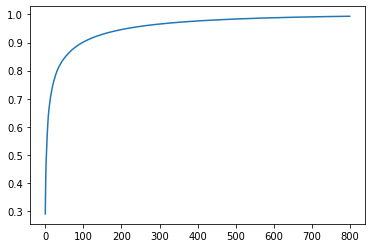

In [9]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [0]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(X_pca[:,:531])

In [15]:
df = pd.DataFrame({'label': y_train[:,0], 'kgroup': kmeans.labels_})
df.groupby(['kgroup', 'label'])['label'].count().to_csv('test.csv', header=True, index=True)

ValueError: ignored

In [0]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [0]:
Z = linkage(X_pca[:,:531], method='ward', metric='euclidean')

In [0]:
plt.title("CAH")
dendrogram(Z,labels=fromage.index,orientation='left',color_threshold=0)
plt.show()